# test notebook for stella ZAMS calc code

In [18]:
# imports
import numpy as np
from scipy.optimize import least_squares

# constants
import constants as c
from scipy.constants import N_A

# plotting
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_context("talk")
plt.style.use('dark_background')
# plt.style.use('default')
plt.rcParams['font.family'] = 'monospace'   # Fonts
plt.rcParams['font.monospace'] = 'DejaVu Sans Mono'

In [19]:
import interpolate
import energy
import density
from guesses import *
from ode import ode
from shootf import shooter, solver

In [20]:
# surface
M_star = 1.33*c.Ms
L_star = (M_star/c.Ms)**(3.5)*c.Ls # eq. 1.88 HKT
R_star = (M_star/c.Ms)**(0.75)*c.Rs # eq. 1.87 HKT
# core
Pc = (3/(8*np.pi))*(c.G*(M_star)**2)/(R_star)**4 # constant density sphere, lower limit!
Tc = (1/2)*((4/(3+5*0.7))/(N_A*c.k))*(c.G*M_star)/(R_star) # constant density sphere
# guess to inflate constant density sphere pressure
P_factor = 1e1
Pc *= P_factor
# initial guess vector
vec = np.array([L_star, Pc, R_star, Tc])
# shootf args
args = (M_star, 0.33, int(1e5), 1e-12, 0.9999, True)
# set limits for the minimizer
bounds = ([L_star*1e-1,Pc/P_factor,R_star*1e-1,Tc], [L_star*1e1, Pc/P_factor*1e4, R_star*1e1, Tc*1e3])

In [4]:
# todo, set x_scale for each variable to enable better tolerance estimate
final = least_squares(shooter, vec, args=args, bounds=bounds, 
                      method='dogbox', loss='arctan', 
                      gtol=None, 
                      xtol=None, 
                      ftol=1e-6, 
                      x_scale='jac',
                     )

2023-05-01 15:26:56,227	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.85706425 -7.246262    0.23646722 -0.53714368]


2023-05-01 15:27:21,514	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.85706425 -7.24626211  0.23646722 -0.53714369]


2023-05-01 15:27:47,162	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.85706425 -7.24626189  0.23646722 -0.53714368]


2023-05-01 15:28:13,317	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.85706426 -7.24626171  0.23646722 -0.53714367]


2023-05-01 15:28:39,446	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.85706425 -7.24626199  0.23646722 -0.53714366]


2023-05-01 15:29:05,898	INFO worker.py:1553 -- Started a local Ray instance.


solved inner


(PoolActor pid=78069) /Users/wbalmer/stellarinteriors/stellaluna/interpolate.py:26: RuntimeWarning: invalid value encountered in log10
(PoolActor pid=78069)   logT_i = np.log10(T_i)
(PoolActor pid=78069) /Users/wbalmer/stellarinteriors/stellaluna/energy.py:50: RuntimeWarning: invalid value encountered in double_scalars
(PoolActor pid=78069)   return 2.57e4 * psi * f_weak * g_pp * rho * X1**2 * T9**(-2/3) * np.exp(-3.381/(T9**(1/3)))
(PoolActor pid=78069) /Users/wbalmer/stellarinteriors/stellaluna/energy.py:57: RuntimeWarning: invalid value encountered in double_scalars
(PoolActor pid=78069)   return 8.24e25*g_cno*X_cno*X1*rho*T9**(-2/3)*np.exp((-15.231*T9**(-1/3))-(T9/0.8)**2)


failed to solve exterior Required step size is less than spacing between numbers.


2023-05-01 15:29:47,780	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.84854898 -7.13185213  0.2393955  -0.24096005]


2023-05-01 15:30:19,214	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.84854898 -7.13185224  0.2393955  -0.24096006]


2023-05-01 15:30:52,974	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.84854898 -7.13185202  0.23939549 -0.24096005]


2023-05-01 15:31:23,729	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.84854899 -7.13185184  0.23939549 -0.24096004]


2023-05-01 15:32:03,215	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.84854898 -7.13185212  0.2393955  -0.24096003]


2023-05-01 15:32:35,959	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[  0.05545832 -23.69794882   0.46032493  -0.0504426 ]


2023-05-01 15:33:07,305	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[  0.05545833 -23.69794922   0.46032493  -0.0504426 ]


2023-05-01 15:33:36,537	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[  0.05545832 -23.69794846   0.46032493  -0.0504426 ]


2023-05-01 15:34:04,695	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[  0.05545798 -23.69794135   0.4603249   -0.05044255]


2023-05-01 15:34:32,892	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[  0.05545832 -23.69794882   0.46032493  -0.05044258]


2023-05-01 15:35:00,735	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.14485525 -5.84941216  0.24763029 -0.03008408]


2023-05-01 15:35:29,829	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.14485526 -5.84941224  0.24763029 -0.03008408]


2023-05-01 15:35:59,734	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.14485525 -5.84941207  0.24763029 -0.03008408]


2023-05-01 15:36:29,039	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.14485519 -5.84941191  0.24763029 -0.03008408]


2023-05-01 15:36:56,665	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.14485526 -5.84941215  0.24763029 -0.03008406]


2023-05-01 15:37:28,132	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.06563769 -2.39124597  0.15575078 -0.06629061]


2023-05-01 15:37:59,365	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.06563769 -2.39124601  0.15575078 -0.06629062]


2023-05-01 15:38:37,901	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.06563769 -2.39124594  0.15575077 -0.06629061]


2023-05-01 15:39:07,857	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.06563764 -2.39124586  0.15575077 -0.06629061]


2023-05-01 15:39:39,901	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.06563771 -2.39124597  0.15575078 -0.0662906 ]


2023-05-01 15:40:07,879	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.07459284 -0.74005879  0.05552256 -0.38097918]


2023-05-01 15:40:35,554	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.07459284 -0.7400588   0.05552256 -0.38097918]


2023-05-01 15:41:01,755	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.07459285 -0.74005878  0.05552256 -0.38097919]


2023-05-01 15:41:28,308	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.07459288 -0.74005875  0.05552255 -0.38097917]


2023-05-01 15:41:54,523	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.0745928  -0.74005877  0.05552256 -0.38097914]


2023-05-01 15:42:20,764	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 2.92272572 -0.07092158  0.0087528  -0.0099957 ]


2023-05-01 15:42:47,629	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.49509644 -0.44086708  0.04120553 -0.14418037]


2023-05-01 15:43:13,430	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.49509643 -0.44086709  0.04120553 -0.14418037]


2023-05-01 15:43:39,621	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.49509644 -0.44086707  0.04120553 -0.14418038]


2023-05-01 15:44:06,197	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.49509641 -0.44086705  0.04120553 -0.14418037]


2023-05-01 15:44:32,207	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.49509654 -0.44086707  0.04120553 -0.14418034]


2023-05-01 15:44:58,258	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.0844166  -0.41616114  0.03485781 -0.22490768]


2023-05-01 15:45:25,907	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.0844166  -0.41616115  0.03485781 -0.22490768]


2023-05-01 15:45:52,168	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.08441661 -0.41616113  0.03485781 -0.22490768]


2023-05-01 15:46:18,438	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.08441658 -0.41616111  0.0348578  -0.22490767]


2023-05-01 15:46:44,800	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.08441666 -0.41616113  0.03485781 -0.22490766]


2023-05-01 15:47:11,171	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.17510293 -0.27137212  0.02807183 -0.08893815]


2023-05-01 15:47:37,779	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.17510292 -0.27137213  0.02807184 -0.08893815]


2023-05-01 15:48:04,240	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.17510291 -0.27137212  0.02807183 -0.08893818]


2023-05-01 15:48:31,522	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.17510291 -0.2713721   0.02807183 -0.08893814]


2023-05-01 15:48:58,126	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.17510302 -0.27137211  0.02807184 -0.08893812]


2023-05-01 15:49:25,644	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.06317512 -0.106724    0.01280646 -0.02777356]


2023-05-01 15:49:51,723	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.06317511 -0.106724    0.01280647 -0.02777356]


2023-05-01 15:50:19,171	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.06317511 -0.106724    0.01280646 -0.02777358]


2023-05-01 15:50:45,269	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.06317512 -0.10672398  0.01280646 -0.02777356]


2023-05-01 15:51:11,490	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.06317521 -0.10672399  0.01280647 -0.02777353]


2023-05-01 15:51:38,059	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00631202 -0.02589523  0.00501425  0.02389212]


2023-05-01 15:52:05,280	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00631201 -0.02589523  0.00501426  0.02389212]


2023-05-01 15:52:32,421	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00631201 -0.02589523  0.00501425  0.0238921 ]


2023-05-01 15:52:59,050	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00631202 -0.02589522  0.00501425  0.02389213]


2023-05-01 15:53:25,994	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00631211 -0.02589522  0.00501426  0.02389215]


2023-05-01 15:53:52,188	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00470879 -0.00155209  0.00023125 -0.00376   ]


2023-05-01 15:54:18,545	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00470878 -0.0015521   0.00023125 -0.00376   ]


2023-05-01 15:54:43,994	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00470878 -0.0015521   0.00023124 -0.00376003]


2023-05-01 15:55:10,354	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00470879 -0.00155209  0.00023125 -0.00375999]


2023-05-01 15:55:35,820	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00470888 -0.00155208  0.00023125 -0.00375997]


2023-05-01 15:56:01,575	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.00021054  0.00019643  0.00014011  0.00011274]


2023-05-01 15:56:27,027	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.00021055  0.00019643  0.00014011  0.00011274]


2023-05-01 15:56:53,555	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.00021055  0.00019643  0.00014011  0.00011271]


2023-05-01 15:57:19,680	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.00021055  0.00019644  0.00014011  0.00011275]


2023-05-01 15:57:45,860	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.00021045  0.00019644  0.00014011  0.00011277]


2023-05-01 15:58:12,723	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-5.42061620e-05  5.74061815e-05  1.60834506e-04  4.72628961e-05]


2023-05-01 15:58:42,509	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-5.42187249e-05  5.74017256e-05  1.60835288e-04  4.72593712e-05]


2023-05-01 15:59:14,857	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-5.42165229e-05  5.74050073e-05  1.60833199e-04  4.72342975e-05]


2023-05-01 15:59:41,740	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-5.42134022e-05  5.74143016e-05  1.60833145e-04  4.72698969e-05]


2023-05-01 16:00:13,589	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-5.41169371e-05  5.74173904e-05  1.60834915e-04  4.72932409e-05]


2023-05-01 16:00:42,868	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 1.02984214e-06  1.59491265e-05  1.65075729e-04 -1.08269947e-05]


2023-05-01 16:01:15,523	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 1.01749116e-06  1.59448375e-05  1.65076525e-04 -1.08307245e-05]


2023-05-01 16:01:44,979	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 1.01947808e-06  1.59479525e-05  1.65074422e-04 -1.08556032e-05]


2023-05-01 16:02:14,266	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 1.02455554e-06  1.59591542e-05  1.65074490e-04 -1.08219478e-05]


2023-05-01 16:02:44,037	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 1.11907146e-06  1.59603356e-05  1.65076139e-04 -1.07966452e-05]


2023-05-01 16:03:13,554	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.75013100e-06  2.30398978e-05  1.64015592e-04 -7.38427566e-06]


2023-05-01 16:03:46,833	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.76248439e-06  2.30356026e-05  1.64016389e-04 -7.38800433e-06]


2023-05-01 16:04:13,034	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.76049524e-06  2.30387235e-05  1.64014285e-04 -7.41288459e-06]


2023-05-01 16:04:39,982	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.75517717e-06  2.30501277e-05  1.64014367e-04 -7.37945694e-06]


2023-05-01 16:05:06,265	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.66090145e-06  2.30511068e-05  1.64016002e-04 -7.35392606e-06]


2023-05-01 16:05:33,657	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.69517907e-07  2.30433375e-05  1.63986494e-04 -8.13108258e-06]


2023-05-01 16:06:00,204	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.81870969e-07  2.30390429e-05  1.63987291e-04 -8.13481155e-06]


2023-05-01 16:06:27,273	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.79882168e-07  2.30421633e-05  1.63985187e-04 -8.15969171e-06]


2023-05-01 16:06:58,881	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.74827631e-07  2.30533560e-05  1.63985252e-04 -8.12601062e-06]


2023-05-01 16:07:30,749	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-7.80288184e-07  2.30545466e-05  1.63986904e-04 -8.10073287e-06]


2023-05-01 16:08:01,870	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.88388777e-07  2.30685883e-05  1.63981846e-04 -8.13007824e-06]


2023-05-01 16:08:29,331	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-9.00739818e-07  2.30642952e-05  1.63982642e-04 -8.13380917e-06]


2023-05-01 16:08:56,466	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.98753069e-07  2.30674140e-05  1.63980539e-04 -8.15868739e-06]


2023-05-01 16:09:22,224	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.93430350e-07  2.30788218e-05  1.63980621e-04 -8.12526395e-06]


2023-05-01 16:09:54,310	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-7.99159122e-07  2.30797973e-05  1.63982255e-04 -8.09972857e-06]


2023-05-01 16:10:29,204	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.76096490e-07  2.30207599e-05  1.63990607e-04 -8.12317609e-06]


2023-05-01 16:10:57,861	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.80892302e-07  2.30591599e-05  1.63984175e-04 -8.12997523e-06]


2023-05-01 16:11:28,082	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.85449405e-07  2.30655455e-05  1.63982388e-04 -8.12844697e-06]


2023-05-01 16:12:00,264	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.85633572e-07  2.30680812e-05  1.63981990e-04 -8.12898302e-06]


2023-05-01 16:12:28,215	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.85679484e-07  2.30687152e-05  1.63981891e-04 -8.12911718e-06]


2023-05-01 16:12:58,420	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.85690572e-07  2.30688741e-05  1.63981866e-04 -8.12915110e-06]


2023-05-01 16:13:26,189	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.87681137e-07  2.30686638e-05  1.63981851e-04 -8.12983508e-06]


2023-05-01 16:13:54,827	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.88211917e-07  2.30686071e-05  1.63981847e-04 -8.13001741e-06]


2023-05-01 16:14:20,541	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-9.00562784e-07  2.30643141e-05  1.63982644e-04 -8.13374850e-06]


2023-05-01 16:14:45,688	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.98576204e-07  2.30674328e-05  1.63980540e-04 -8.15862656e-06]


2023-05-01 16:15:11,951	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-8.93253518e-07  2.30788406e-05  1.63980622e-04 -8.12520310e-06]


2023-05-01 16:15:37,317	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-7.98982235e-07  2.30798161e-05  1.63982257e-04 -8.09966772e-06]


In [5]:
final

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-8.882e-07  2.307e-05  1.640e-04 -8.130e-06]
           x: [ 1.038e+34  1.965e+17  9.919e+10  1.694e+07]
        cost: 1.3744546427324974e-08
         jac: [[-7.985e-35 -3.539e-18 -3.411e-12  3.535e-07]
               [-2.775e-35 -4.009e-19  6.923e-12  4.441e-08]
               [ 5.150e-36 -4.463e-19 -8.288e-13  1.623e-09]
               [-2.412e-35 -9.768e-18  3.257e-12  1.202e-07]]
        grad: [ 4.714e-40  1.328e-25  3.592e-19 -1.005e-15]
  optimality: 1.0052939878477195e-15
 active_mask: [0 0 0 0]
        nfev: 28
        njev: 19

In [6]:
if np.sum(final.active_mask**2) != 0:
    print('something ran up against a bound')

In [7]:
solution = solver(final.x, M_star=args[0], M_fit=args[1], n=1e6, in_factor=args[3], out_factor=args[4], multithread=args[5])

2023-05-01 16:22:09,231	INFO worker.py:1553 -- Started a local Ray instance.


In [8]:
# what is an appropriate P_factor to speed up convergence?
print('ratio between constant density Pc and converged solution',solution[2].max()/(Pc/P_factor))

ratio between constant density Pc and converged solution 194.6747904617228


In [9]:
print('ratio between constant density Tc and converged solution',solution[4].max()/Tc)

ratio between constant density Tc and converged solution 2.2353084749288588


In [10]:
with open('converged_interior_{}.npy'.format(M_star/c.Ms), 'wb') as f:
    np.save(f, solution)

In [11]:
solution = np.load('converged_interior_{}.npy'.format(M_star/c.Ms))

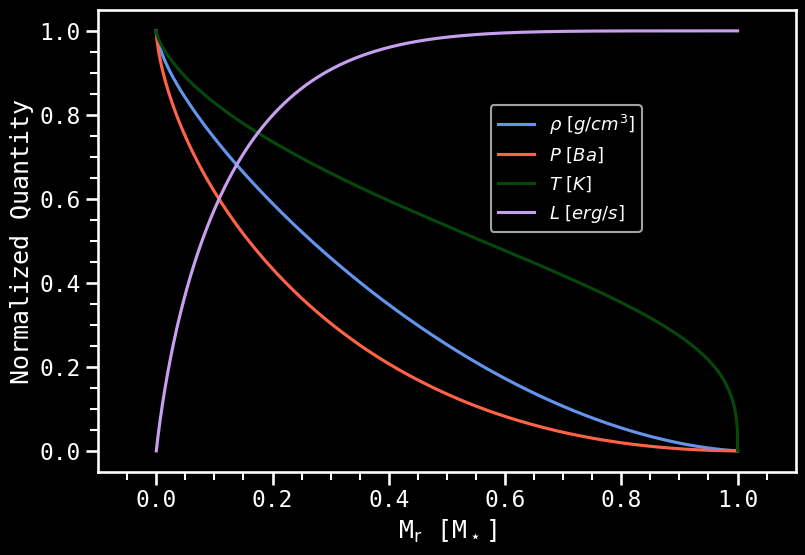

In [22]:
# a figure like 9.1 in HKT but in mass space, y-values near 1
plt.figure(figsize=(9,6))

plt.plot(solution[0]/M_star, solution[5]/solution[5].max(), color='cornflowerblue', label=r'$\rho~[g/cm^3]$'.format())
plt.plot(solution[0]/M_star, solution[2]/solution[2].max(), color='tomato', label=r'$P~[Ba]$')
plt.plot(solution[0]/M_star, solution[4]/solution[4].max(), color='xkcd:forest green', label=r'$T~[K]$')
plt.plot(solution[0]/M_star, solution[1]/solution[1].max(), color='xkcd:lavender', label=r'$L~[erg/s]$')

plt.xlabel(r'M$_\mathrm{r}$ [M$_\star$]')
plt.ylabel(r'Normalized Quantity')
plt.legend(fontsize=13, bbox_to_anchor=(0.55,0.5))
plt.xlim(-0.1,1.1)
plt.minorticks_on()

plt.savefig('./figures/run_over_mass_alt_{}.png'.format(M_star/c.Ms), dpi=300, bbox_inches='tight', transparent=True)

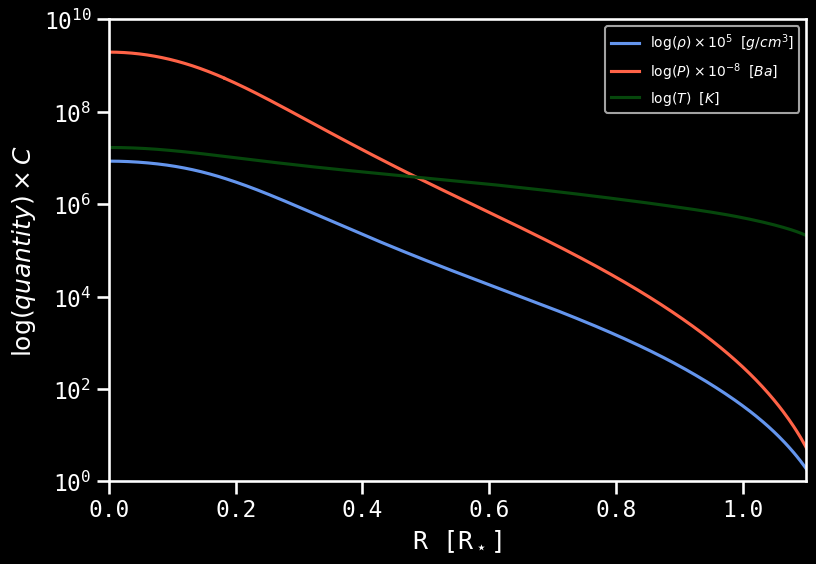

In [23]:
# reproduce figure 9.1 in HKT but in mass space

plt.figure(figsize=(9,6))

plt.plot(solution[3]/R_star, solution[5]*1e5, color='cornflowerblue', label=r'$\log(\rho)\times10^5$ $[g/cm^3]$')
plt.plot(solution[3]/R_star, solution[2]*1e-8, color='tomato', label=r'$\log(P)\times10^{-8}$ $[Ba]$')
plt.plot(solution[3]/R_star, solution[4], color='xkcd:forest green', label=r'$\log(T)$ $[K]$')

plt.yscale('log')
plt.xlabel(r'R [R$_\star$]')
plt.ylabel(r'$\log(quantity)\times C$')
plt.legend(fontsize=10)
plt.ylim(1,1e10)
plt.xlim(0,1.1)

plt.savefig('./figures/run_over_radius_HKT9-1_alt_{}.png'.format(M_star/c.Ms), dpi=300, bbox_inches='tight', transparent=True)

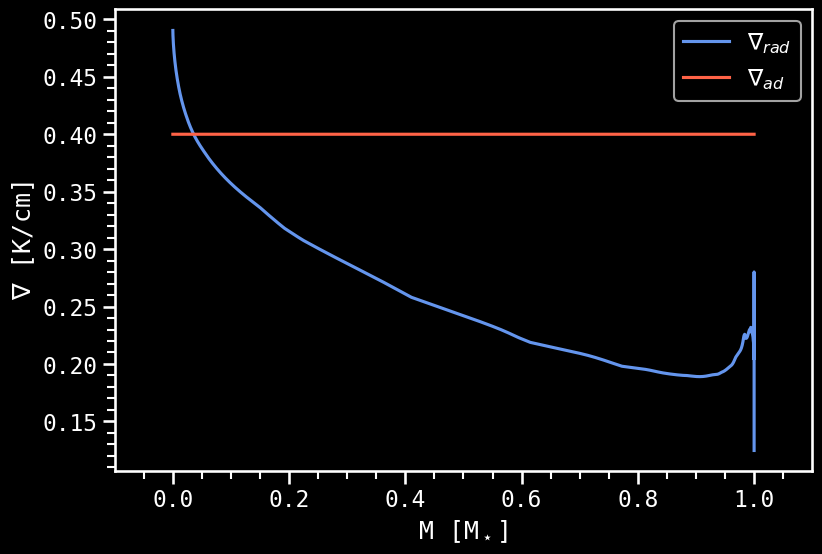

In [24]:
plt.figure(figsize=(9,6))

plt.plot(solution[0]/M_star, solution[-1], color='cornflowerblue', label=r'$\nabla_{rad}$')
plt.plot(solution[0]/M_star, np.zeros_like(solution[0])+0.4, color='tomato', label=r'$\nabla_{ad}$')

# plt.yscale('log')
plt.xlabel(r'M [M$_\star$]')
plt.ylabel(r'$\nabla$ [K/cm]')
plt.legend()
# plt.ylim(1,1e10)
plt.xlim(-0.1,1.1)
plt.minorticks_on()
plt.savefig('./figures/del_over_mass_alt_{}.png'.format(M_star/c.Ms), dpi=300, bbox_inches='tight', transparent=True)


In [15]:
# central density vs avg density
converged_concentration = solution[5].max()/(4*np.pi*M_star/(3*R_star**3))

print("rho_c/rho_avg is", str(round(converged_concentration,2)))

rho_c/rho_avg is 4.96


/var/folders/0q/4ls9h2fn4lv90qs43vdtzvkw0002tl/T/ipykernel_77867/3156873861.py:7: RuntimeWarning: invalid value encountered in power
  return (psi, -np.power(theta, n) - 2 * psi / xi)


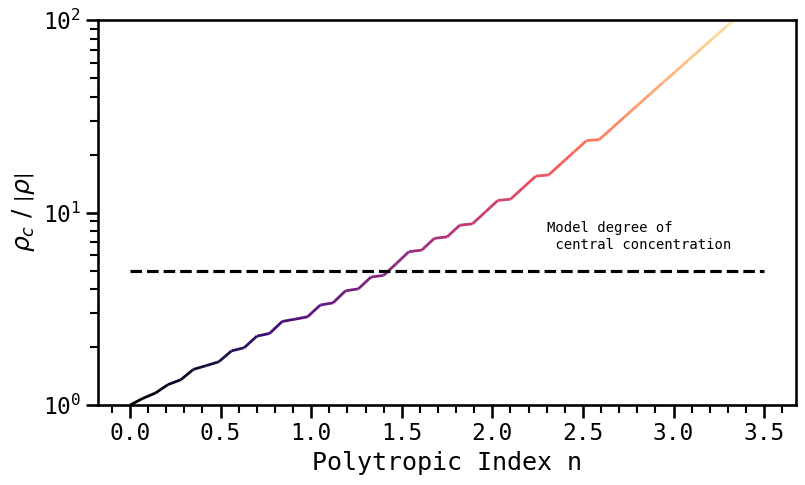

In [16]:
from scipy.integrate import solve_ivp

# compare to polytrope

def dtheta(xi, y, n):
    theta, psi = y
    return (psi, -np.power(theta, n) - 2 * psi / xi)

ns = np.linspace(0, 3.5, num=51) # a reasonable number of n for plotting
ts = np.logspace(np.log10(1e-15), np.log10(1000.), num=1000) # dense enough to look smooth

concentrations = np.zeros(ns.shape[0])
for i, n in enumerate(ns):
    soln = solve_ivp(dtheta, [1e-16, 1001.], [1., 0.], args=[n], t_eval=ts)
    # degree of central concentration
    concentration = 1/3 * (soln.t[np.argmin(np.abs(soln.y[0]))]/(-1*soln.y[1][np.argmin(np.abs(soln.y[0]))]))
#     print("for n={}, rho_c/rho_avg is".format(n), str(round(concentration,2)))
    concentrations[i] += concentration

x = ns
y = concentrations
    
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(1, 1, figsize=(9,5))

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
from matplotlib.collections import LineCollection
lc = LineCollection(segments, cmap='magma', norm=norm)
# Set the values used for colormapping
lc.set_array(x)
lc.set_linewidth(2)
line = axs.add_collection(lc)
# cb = fig.colorbar(line, ax=axs)
# cb.ax.set_title('n')
plt.hlines(converged_concentration, 0, 3.5, ls='--', color='k')
plt.annotate('Model degree of \n central concentration', (2.3,6.5), fontsize=10)

plt.minorticks_on()
plt.ylim(1, 1e2)
plt.yscale('log')

plt.xlabel('Polytropic Index n')
plt.ylabel(r'$\rho_c~/~\left|\rho\right|}$')

plt.savefig('./figures/central_concentration_polytropes_{}.png'.format(M_star/c.Ms), dpi=300, bbox_inches='tight', transparent=True)